In [12]:
import torch
import torch.nn as  nn
import torch.nn.functional as F
import pandas as pd
from d2l import torch as d2l

In [13]:
FullDaily=pd.read_excel("D:\Data\P2P\FullDailyShutDownInf0630.xlsx")

In [14]:
FullDaily

,black_time,平台失联,涉及司法或者介入,未知,运营暂停或清理,TotalShutDown,Cum_平台失联,Cum_涉及司法或者介入,Cum_未知,Cum_运营暂停或清理,Cum_TotalShutDown
0,2013-04-02,0,0,0,1,1,0,0,0,1,1
1,2013-04-03,0,0,0,0,0,0,0,0,1,1
2,2013-04-04,0,0,0,0,0,0,0,0,1,1
3,2013-04-05,0,0,0,0,0,0,0,0,1,1
4,2013-04-06,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2456,2019-12-23,0,0,0,0,0,3017,608,32,2141,5798
2457,2019-12-24,0,0,0,0,0,3017,608,32,2141,5798
2458,2019-12-25,0,0,0,0,0,3017,608,32,2141,5798
2459,2019-12-26,0,0,0,0,0,3017,608,32,2141,5798


In [15]:
# -*- coding: utf-8 -*-
"""main.ipynb
Automatically generated by Colaboratory.
Original file is located at
    https://colab.research.google.com/drive/1W2_OxJ3JcWnvnG8wugwms-ETq0pRYX_v
"""
 
import numpy as np
import pandas as pd
 
 
data = FullDaily["TotalShutDown"]
print(data.shape)

(2461,)


In [16]:
import matplotlib.pyplot as plt
 
data = data.astype('float32')
mx = np.max(data)
mn = np.min(data)
data = (data - mn) / (mx - mn)
 
input_len = 100
 
def generate_dataset(data, days_for_train):
    dataset_x, dataset_y = [], []
    for i in range(len(data) - days_for_train):
        cur_x = data[i:(i + days_for_train)]
        cur_y = data[i + days_for_train]
        dataset_x.append(cur_x)
        dataset_y.append(cur_y)
    return np.array(dataset_x), np.array(dataset_y)


In [17]:
mx

63.0

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
 
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))


True
1
NVIDIA GeForce RTX 3060 Laptop GPU


In [19]:
dataset_x, dataset_y = generate_dataset(data, input_len)
train_len = int(len(dataset_x) * 0.7)
train_x, train_y = dataset_x[:train_len], dataset_y[:train_len]
train_x, train_y = torch.from_numpy(train_x), torch.from_numpy(train_y)
train_x = train_x.reshape(-1, 1, input_len)
train_y = train_y.reshape(-1, 1, 1)

In [20]:
class Regression(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super().__init__()
        
        self.gru = nn.GRU(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)
        #self.dropout = nn.Dropout(p=0.1)
    
    def forward(self, _x):
        x, _ = self.gru(_x)
        s, b, h = x.shape
        x = x.reshape(s * b, h)
        x = self.fc(x)
        x = x.reshape(s, b, 1)
        #x = self.dropout(x)
        return x
 

In [21]:
loss_function = nn.MSELoss()
epochs = 1000
model = Regression(input_len, hidden_size=10, output_size=1, num_layers=1)
opt = optim.SGD(model.parameters(), lr=0.2)
 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
 
model = model.to(device)
train_x = train_x.to(device)
train_y = train_y.to(device)
 
model.train()
 
for epoch in range(epochs):
    opt.zero_grad()
    
    out = model.forward(train_x)
    loss = loss_function(out, train_y)
    
    loss.backward()
    opt.step()
    
    if (epoch + 1) % 100 == 0:
        print("Epoch", epoch+1)
        print("Loss:", loss.item())
 
model = model.eval()
dataset_x = dataset_x.reshape(-1, 1, input_len)
dataset_x = torch.from_numpy(dataset_x).to(device)
 
pred = model.forward(dataset_x)
pred = pred.reshape(len(dataset_x))
pred = torch.cat((torch.zeros(input_len), pred.cpu()))
pred = pred.detach().numpy()
 
assert len(pred) == len(data)
 

Epoch 100
Loss: 0.006984072737395763
Epoch 200
Loss: 0.006443342659622431
Epoch 300
Loss: 0.006148199085146189
Epoch 400
Loss: 0.0059628114104270935
Epoch 500
Loss: 0.005837431643158197
Epoch 600
Loss: 0.005748199298977852
Epoch 700
Loss: 0.005682158283889294
Epoch 800
Loss: 0.00563178863376379
Epoch 900
Loss: 0.005592337343841791
Epoch 1000
Loss: 0.005560643505305052


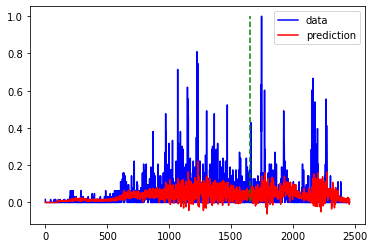

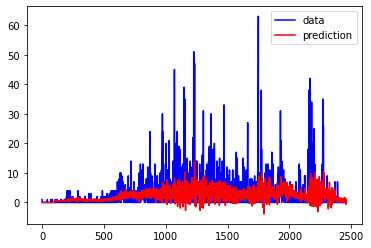

Predicted price of 2020.10.26: 0.8790262


In [22]:
plt.plot(data, 'b', label='data')
plt.plot(pred, 'r', label='prediction')

plt.plot((train_len, train_len), (0, 1), 'g--')
plt.legend()
plt.show()
 
data *= (mx - mn)
data += mn
pred *= (mx - mn)
pred += mn
plt.plot(data, 'b', label='data')
plt.plot(pred, 'r', label='prediction')
plt.plot((train_len, train_len), (0, 1), 'g--')
plt.legend()
plt.show()
 
print("Predicted price of 2020.10.26:", pred[-1])
 